Hello Fellow Kagglers,

This notebook gives an analysis of the competition dataset and demonstrates the preprocessing of the dataset, giving the X/y data to use for training.

The processing is as follows:

1) Select dominant hand based on most number of non empty hand frames

2) Filter out all frames with missing dominant hand coordinates

3) Resize video to 256 frames

This is a work in progress and updates will follow.

The processed data could help with making a baseline.

Soon, a training notebook will follow with the corresponding inference.

Exited to continue working on sign language!

**Update V2**

* Preprocessing pipeline that passes submission
* Excluding samples with low frames per character ratio
* Added phrase type

Training + Inference notebook coming soon.

[Training + Inference Notebook](https://www.kaggle.com/markwijkhuizen/aslfr-transformer-training-inference)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sn
import tensorflow as tf

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from pathlib import Path

import glob
import sys
import os
import math
import gc
import sys
import sklearn
import time
import json
import re

# TQDM Progress Bar With Pandas Apply Function
tqdm.pandas()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Character To Ordinal Encoding

In [2]:
# Read Character to Ordinal Encoding Mapping
with open('/kaggle/input/asl-fingerspelling/character_to_prediction_index.json') as json_file:
    CHAR2ORD = json.load(json_file)
    
# Character to Ordinal Encoding Mapping   
display(pd.Series(CHAR2ORD).to_frame('Ordinal Encoding'))

,Ordinal Encoding
,0
!,1
#,2
$,3
%,4
&,5
',6
(,7
),8
*,9


In [3]:
# Number of Unique Characters
N_UNIQUE_CHARACTERS = len(CHAR2ORD)
print(f'N_UNIQUE_CHARACTERS: {N_UNIQUE_CHARACTERS}')

N_UNIQUE_CHARACTERS: 59


# Global Config

In [4]:
# If Notebook Is Run By Committing or In Interactive Mode For Development
IS_INTERACTIVE = os.environ['KAGGLE_KERNEL_RUN_TYPE'] == 'Interactive'
# Describe Statistics Percentiles
PERCENTILES = [0.01, 0.10, 0.05, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99, 0.999]
# Global Random Seed
SEED = 42
# Number of Frames to resize recording to
N_TARGET_FRAMES = 128
# Global debug flag, takes subset of train
DEBUG = False
# Fast Processing
FAST= False
# Number of Unique Characters To Predict + Pad Token + SOS Token + EOS Token
N_UNIQUE_CHARACTERSPAD_TOKEN = len(CHAR2ORD)
SOS_TOKEN = len(CHAR2ORD) + 1 # Start Of Sentence
EOS_TOKEN = len(CHAR2ORD) + 2 # End Of Sentence

# Plot Config

In [5]:
# MatplotLib Global Settings
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.titlesize'] = 24

# Utils

In [6]:
# Prints Shape and Dtype For List Of Variables
def print_shape_dtype(l, names):
    for e, n in zip(l, names):
        print(f'{n} shape: {e.shape}, dtype: {e.dtype}')

# Read Train

In [7]:
# Read Train DataFrame
if DEBUG:
    train = pd.read_csv('/kaggle/input/asl-fingerspelling/train.csv').head(5000)
else:
    train = pd.read_csv('/kaggle/input/asl-fingerspelling/train.csv')

# Number Of Train Samples
N_SAMPLES = len(train)
print(f'N_SAMPLES: {N_SAMPLES}')

display(train.info())
display(train.head())

N_SAMPLES: 67208
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67208 entries, 0 to 67207
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   path            67208 non-null  object
 1   file_id         67208 non-null  int64 
 2   sequence_id     67208 non-null  int64 
 3   participant_id  67208 non-null  int64 
 4   phrase          67208 non-null  object
dtypes: int64(3), object(2)
memory usage: 2.6+ MB


None

,path,file_id,sequence_id,participant_id,phrase
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road


# Phrase Type

In [8]:
"""
Attempt to retrieve phrase type
Could be used for pretraining or type specific inference
 *) Phone Number\
 *) URL
 *3) Addres
"""
def get_phrase_type(phrase):
    # Phone Number
    if re.match(r'^[\d+-]+$', phrase):
        return 'phone_number'
    # url
    elif any([substr in phrase for substr in ['www', '.', '/']]) and ' ' not in phrase:
        return 'url'
    # Address
    else:
        return 'address'
    
train['phrase_type'] = train['phrase'].apply(get_phrase_type)

# Add File Path

In [9]:
# Get complete file path to file
def get_file_path(path):
    return f'/kaggle/input/asl-fingerspelling/{path}'

train['file_path'] = train['path'].apply(get_file_path)

# Phrase Processing

In [10]:
# Split Phrase To Char Tuple
train['phrase_char'] = train['phrase'].apply(tuple)
# Character Length of Phrase
train['phrase_char_len'] = train['phrase_char'].apply(len)

# Maximum Input Length
MAX_PHRASE_LENGTH = train['phrase_char_len'].max()
print(f'MAX_PHRASE_LENGTH: {MAX_PHRASE_LENGTH}')

# Train DataFrame indexed by sequence_id to convenientlyy lookup recording data
train_sequence_id = train.set_index('sequence_id')

MAX_PHRASE_LENGTH: 31


In [11]:
# Phrase Character Length Statistics
display(train['phrase_char_len'].describe(percentiles=PERCENTILES).to_frame().round(1))

,phrase_char_len
count,67208.0
mean,17.8
std,5.7
min,1.0
1%,8.0
5%,11.0
10%,12.0
25%,12.0
50%,17.0
75%,22.0


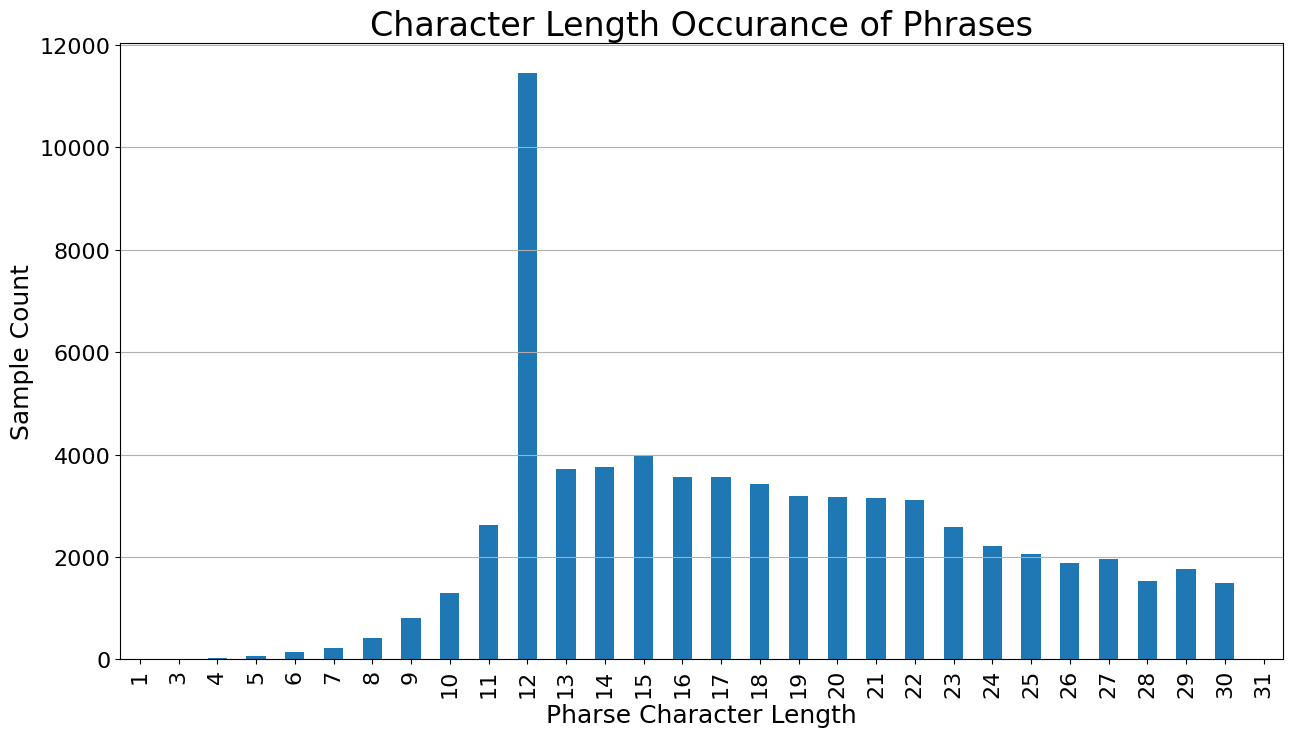

In [12]:
# Character Count Occurance
plt.figure(figsize=(15,8))
plt.title('Character Length Occurance of Phrases')
train['phrase_char_len'].value_counts().sort_index().plot(kind='bar')
plt.xlim(-0.50, train['phrase_char_len'].max() - 1.50)
plt.xlabel('Pharse Character Length')
plt.ylabel('Sample Count')
plt.grid(axis='y')
plt.show()

# Find Unique Character

In [13]:
# Use Set to keep track of unique characters in phrases
UNIQUE_CHARACTERS = set()

for phrase in tqdm(train['phrase_char']):
    for c in phrase:
        UNIQUE_CHARACTERS.add(c)
        
# Sorted Unique Character
UNIQUE_CHARACTERS = np.array(sorted(UNIQUE_CHARACTERS))
# Number of Unique Characters
N_UNIQUE_CHARACTERS = len(UNIQUE_CHARACTERS)
print(f'N_UNIQUE_CHARACTERS: {N_UNIQUE_CHARACTERS}')

  0%|          | 0/67208 [00:00<?, ?it/s]

N_UNIQUE_CHARACTERS: 59


# Example Parquet File

In [14]:
# Read First Parquet File
example_parquet_df = pd.read_parquet(train['file_path'][0])

# Each parquet file contains 1000 recordings
print(f'# Unique Recording: {example_parquet_df.index.nunique()}')
# Display DataFrame layout
display(example_parquet_df.head())

# Unique Recording: 1000


,frame,x_face_0,x_face_1,x_face_2,x_face_3,x_face_4,x_face_5,x_face_6,x_face_7,x_face_8,...,z_right_hand_11,z_right_hand_12,z_right_hand_13,z_right_hand_14,z_right_hand_15,z_right_hand_16,z_right_hand_17,z_right_hand_18,z_right_hand_19,z_right_hand_20
sequence_id,,,,,,,,,,,,,,,,,,,,,
1816796431,0,0.710588,0.699951,0.705657,0.691768,0.699669,0.701980,0.709724,0.610405,0.712660,...,-0.245855,-0.269148,-0.129743,-0.251501,-0.278687,-0.266530,-0.152852,-0.257519,-0.275822,-0.266876
1816796431,1,0.709525,0.697582,0.703713,0.691016,0.697576,0.700467,0.709796,0.616540,0.713729,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1816796431,2,0.711059,0.700858,0.706272,0.693285,0.700825,0.703319,0.711549,0.615606,0.715143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1816796431,3,0.712799,0.702518,0.707840,0.694899,0.702445,0.704794,0.712483,0.625044,0.715677,...,-0.370770,-0.408097,-0.185217,-0.325494,-0.343373,-0.328294,-0.203126,-0.315719,-0.326104,-0.314282
1816796431,4,0.712349,0.705451,0.709918,0.696006,0.705180,0.706928,0.712685,0.614356,0.714875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Video Statistics

In [15]:
# Number of parquet chunks to analyse
N = 5 if IS_INTERACTIVE else 25
# Number of Unique Frames in Recording
N_UNIQUE_FRAMES = []

UNIQUE_FILE_PATHS = pd.Series(train['file_path'].unique())

for idx, file_path in enumerate(tqdm(UNIQUE_FILE_PATHS.sample(N, random_state=SEED))):
    df = pd.read_parquet(file_path)
    for group, group_df in df.groupby('sequence_id'):
        N_UNIQUE_FRAMES.append(group_df['frame'].nunique())

# Convert to Numpy Array
N_UNIQUE_FRAMES = np.array(N_UNIQUE_FRAMES)

  0%|          | 0/5 [00:00<?, ?it/s]

,Value
count,4996
mean,160
std,83
min,1
1%,6
5%,36
10%,68
25%,104
50%,150
75%,206


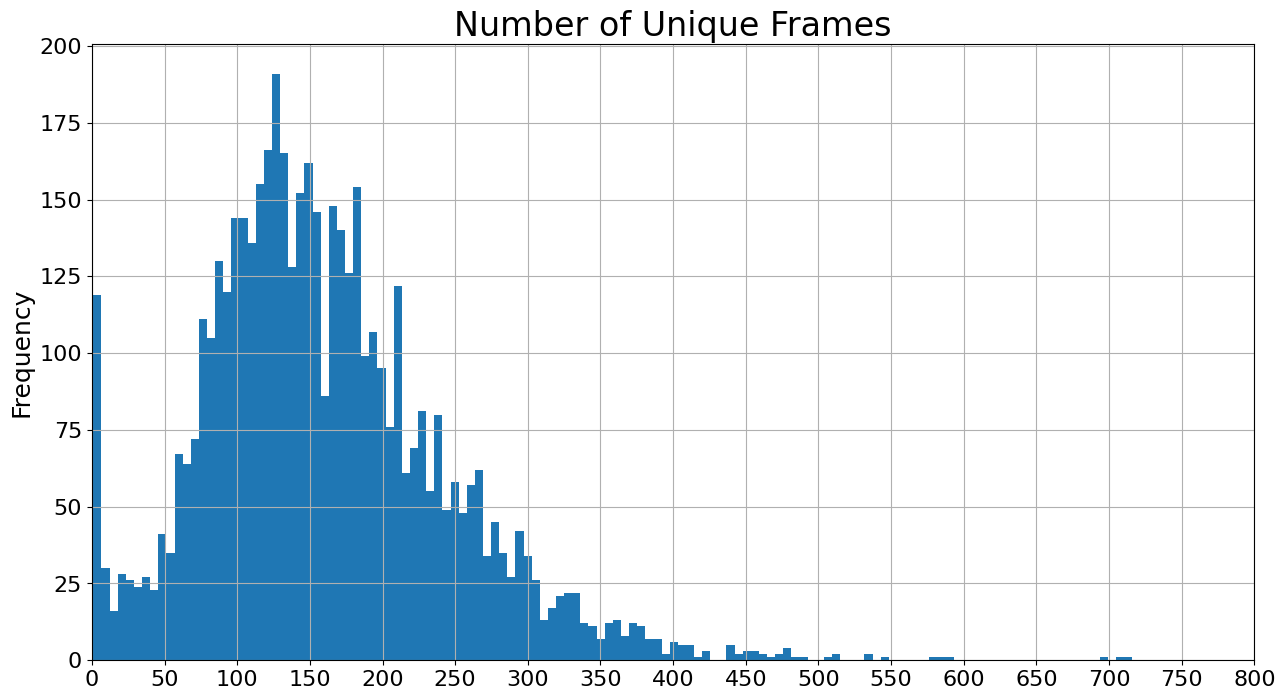

In [16]:
# Number of unique frames in each video
display(pd.Series(N_UNIQUE_FRAMES).describe(percentiles=PERCENTILES).to_frame('Value').astype(int))

plt.figure(figsize=(15,8))
plt.title('Number of Unique Frames', size=24)
pd.Series(N_UNIQUE_FRAMES).plot(kind='hist', bins=128)
plt.grid()
xlim = math.ceil(plt.xlim()[1])
plt.xlim(0, xlim)
plt.xticks(np.arange(0, xlim+50, 50))
plt.show()

  0%|          | 0/401 [00:00<?, ?it/s]

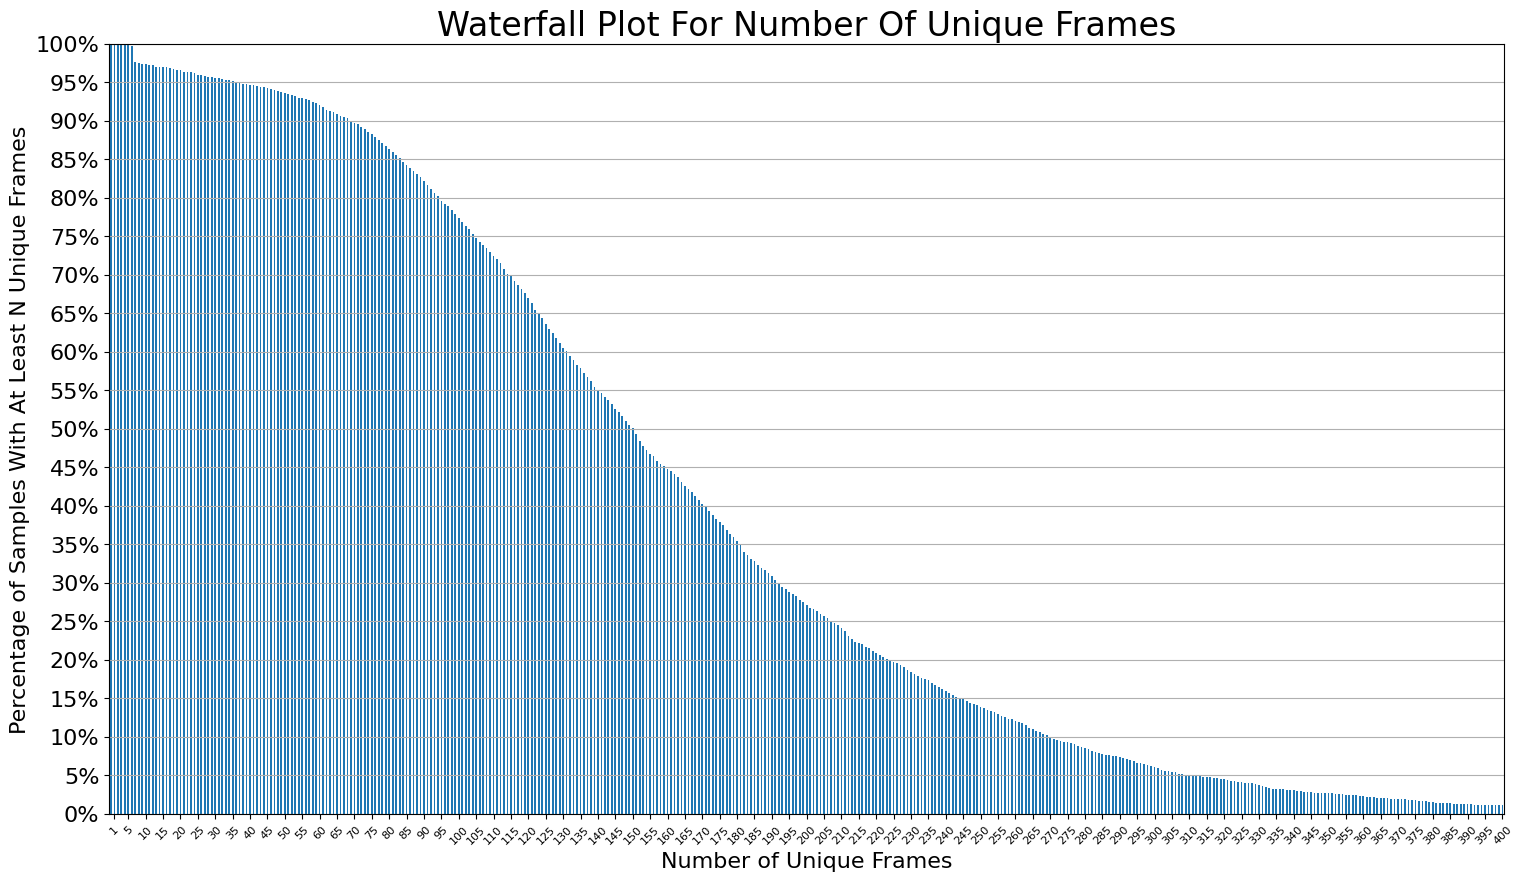

In [17]:
# With N_TARGET_FRAMES = 256 ~85% will be below
N_UNIQUE_FRAMES_WATERFALL = []
# Maximum Number of Unique Frames to use
N_MAX_UNIQUE_FRAMES = 400
# Compute Percentage
for n in tqdm(range(0,N_MAX_UNIQUE_FRAMES+1)):
    N_UNIQUE_FRAMES_WATERFALL.append(sum(N_UNIQUE_FRAMES >= n) / len(N_UNIQUE_FRAMES) * 100)

plt.figure(figsize=(18,10))
plt.title('Waterfall Plot For Number Of Unique Frames')
pd.Series(N_UNIQUE_FRAMES_WATERFALL).plot(kind='bar')
plt.grid(axis='y')
plt.xticks([1] + np.arange(5, N_MAX_UNIQUE_FRAMES+5, 5).tolist(), size=8, rotation=45)
plt.xlabel('Number of Unique Frames', size=16)
plt.yticks(np.arange(0, 100+5, 5), [f'{i}%' for i in range(0,100+5,5)])
plt.ylim(0, 100)
plt.ylabel('Percentage of Samples With At Least N Unique Frames', size=16)
plt.show()

# Landmark Indices

In [18]:
def get_idxs(df, words_pos, words_neg=[], ret_names=True, idxs_pos=None):
    idxs = []
    names = []
    for w in words_pos:
        for col_idx, col in enumerate(example_parquet_df.columns):
            # Exclude Non Landmark Columns
            if col in ['frame']:
                continue
                
            col_idx = int(col.split('_')[-1])
            # Check if column name contains all words
            if (w in col) and (idxs_pos is None or col_idx in idxs_pos) and all([w not in col for w in words_neg]):
                idxs.append(col_idx)
                names.append(col)
    # Convert to Numpy arrays
    idxs = np.array(idxs)
    names = np.array(names)
    # Returns either both column indices and names
    if ret_names:
        return idxs, names
    # Or only columns indices
    else:
        return idxs

In [19]:
# Lips Landmark Face Ids
LIPS_LANDMARK_IDXS = np.array([
        61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
        291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
        78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
        95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
    ])

# Landmark Indices for Left/Right hand without z axis in raw data
LEFT_HAND_IDXS0, LEFT_HAND_NAMES0 = get_idxs(example_parquet_df, ['left_hand'], ['z'])
RIGHT_HAND_IDXS0, RIGHT_HAND_NAMES0 = get_idxs(example_parquet_df, ['right_hand'], ['z'])
LIPS_IDXS0, LIPS_NAMES0 = get_idxs(example_parquet_df, ['face'], ['z'], idxs_pos=LIPS_LANDMARK_IDXS)
COLUMNS0 = np.concatenate((LEFT_HAND_NAMES0, RIGHT_HAND_NAMES0, LIPS_NAMES0))
N_COLS0 = len(COLUMNS0)
# Only X/Y axes are used
N_DIMS0 = 2

print(f'N_COLS0: {N_COLS0}')

N_COLS0: 164


In [20]:
# Landmark Indices in subset of dataframe with only COLUMNS selected
LEFT_HAND_IDXS = np.argwhere(np.isin(COLUMNS0, LEFT_HAND_NAMES0)).squeeze()
RIGHT_HAND_IDXS = np.argwhere(np.isin(COLUMNS0, RIGHT_HAND_NAMES0)).squeeze()
LIPS_IDXS = np.argwhere(np.isin(COLUMNS0, LIPS_NAMES0)).squeeze()
N_COLS = N_COLS0
# Only X/Y axes are used
N_DIMS = 2

print(f'N_COLS: {N_COLS}')

N_COLS: 164


In [21]:
# Indices in processed data by axes with only dominant hand
HAND_X_IDXS = np.array(
        [idx for idx, name in enumerate(LEFT_HAND_NAMES0) if 'x' in name]
    ).squeeze()
HAND_Y_IDXS = np.array(
        [idx for idx, name in enumerate(LEFT_HAND_NAMES0) if 'y' in name]
    ).squeeze()
# Names in processed data by axes
HAND_X_NAMES = LEFT_HAND_NAMES0[HAND_X_IDXS]
HAND_Y_NAMES = LEFT_HAND_NAMES0[HAND_Y_IDXS]

# Number Of Non-NaN Frames

In [22]:
"""
    Tensorflow layer to process data in TFLite
    Data needs to be processed in the model itself, so we can not use Python
""" 
class PreprocessLayerNonNaN(tf.keras.layers.Layer):
    def __init__(self):
        super(PreprocessLayerNonNaN, self).__init__()
    
    @tf.function(
        input_signature=(tf.TensorSpec(shape=[None,N_COLS0], dtype=tf.float32),),
    )
    def call(self, data0):
        # Fill NaN Values With 0
        data = tf.where(tf.math.is_nan(data0), 0.0, data0)
        
        # Hacky
        data = data[None]
        
        # Empty Hand Frame Filtering
        hands = tf.slice(data, [0,0,0], [-1, -1, 84])
        hands = tf.abs(hands)
        mask = tf.reduce_sum(hands, axis=2)
        mask = tf.not_equal(mask, 0)
        data = data[mask][None]
        data = tf.squeeze(data, axis=[0])
        
        return data
    
preprocess_layer_non_nan = PreprocessLayerNonNaN()

In [23]:
# Unique Parquet Files
UNIQUE_FILE_PATHS = pd.Series(train['file_path'].unique())
# Number of parquet chunks to analyse
N = 5 if (IS_INTERACTIVE or FAST) else len(UNIQUE_FILE_PATHS)
# Number of Non Nan Frames in Recording
N_NON_NAN_FRAMES = []

for idx, file_path in enumerate(tqdm(UNIQUE_FILE_PATHS.sample(N, random_state=SEED))):
    df = pd.read_parquet(file_path)
    for group, group_df in df.groupby('sequence_id'):
        frames = preprocess_layer_non_nan(group_df[COLUMNS0].values).numpy()
        N_NON_NAN_FRAMES.append(len(frames))

# Convert to Numpy Array
N_NON_NAN_FRAMES = pd.Series(N_NON_NAN_FRAMES).to_frame('# Frames')

  0%|          | 0/5 [00:00<?, ?it/s]

,# Frames
count,4996
mean,94
std,74
min,1
1%,1
5%,5
10%,11
25%,35
50%,82
75%,135


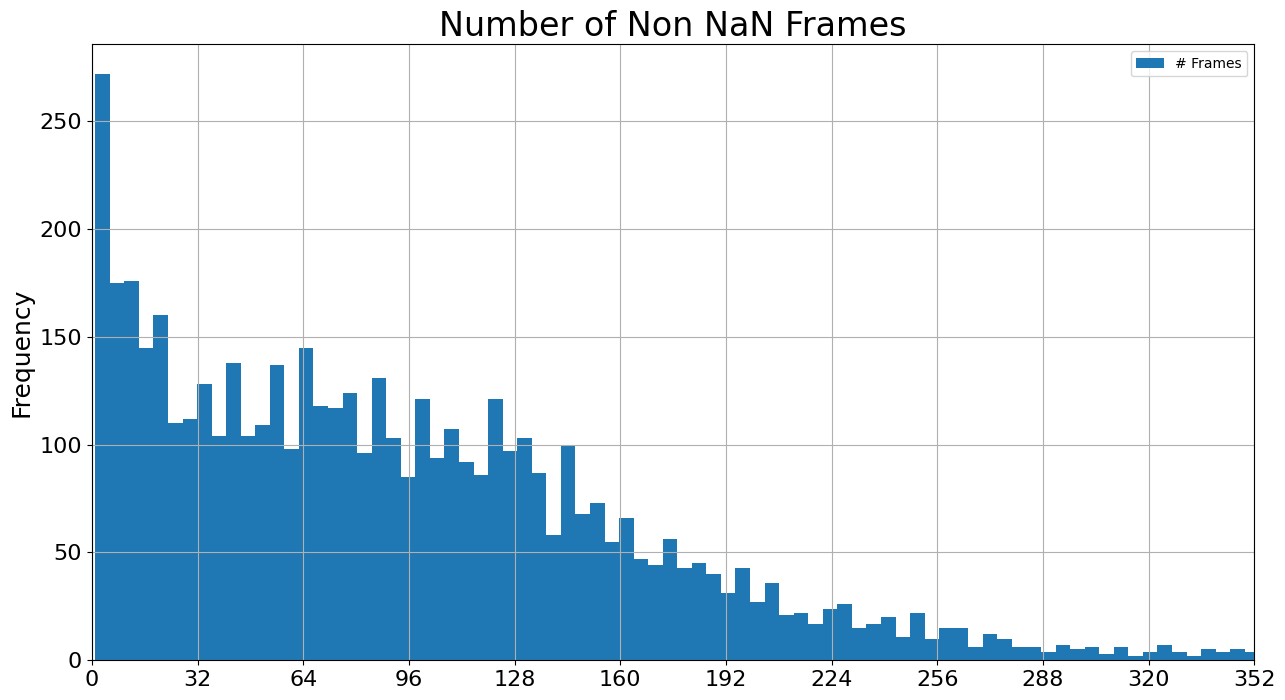

In [24]:
# Number of frames in each video with hand coordinates
display(N_NON_NAN_FRAMES.describe(percentiles=PERCENTILES).astype(int))

N_NON_NAN_FRAMES.plot(kind='hist', bins=128, figsize=(15,8))
plt.title('Number of Non NaN Frames', size=24)
plt.grid()
xlim = np.percentile(N_NON_NAN_FRAMES, 99)
plt.xlim(0, xlim)
plt.xticks(np.arange(0, xlim+32, 32))
plt.show()

# Tensorflow Preprocess Layer

In [25]:
"""
    Tensorflow layer to process data in TFLite
    Data needs to be processed in the model itself, so we can not use Python
""" 
class PreprocessLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(PreprocessLayer, self).__init__()
    
    @tf.function(
        input_signature=(tf.TensorSpec(shape=[None,N_COLS0], dtype=tf.float32),),
    )
    def call(self, data0, resize=True):
        # Fill NaN Values With 0
        data = tf.where(tf.math.is_nan(data0), 0.0, data0)
        
        # Hacky
        data = data[None]
        
        # Empty Hand Frame Filtering
        hands = tf.slice(data, [0,0,0], [-1, -1, 84])
        hands = tf.abs(hands)
        mask = tf.reduce_sum(hands, axis=2)
        mask = tf.not_equal(mask, 0)
        data = data[mask][None]
        
        # Pad Zeros
        N_FRAMES = len(data[0])
        if N_FRAMES < N_TARGET_FRAMES:
            data = tf.concat((
                data,
                tf.zeros([1,N_TARGET_FRAMES-N_FRAMES,N_COLS], dtype=tf.float32)
            ), axis=1)
        # Downsample
        data = tf.image.resize(
            data,
            [1, N_TARGET_FRAMES],
            method=tf.image.ResizeMethod.BILINEAR,
        )
        
        # Squeeze Batch Dimension
        data = tf.squeeze(data, axis=[0])
        
        return data
    
preprocess_layer = PreprocessLayer()

inputs = group_df[COLUMNS0].values
inputs = inputs[:1]

frames = preprocess_layer(inputs)

print(f'inputs shape: {inputs.shape}')
print(f'frames shape: {frames.shape}, NaN count: {np.isnan(frames).sum()}')

inputs shape: (1, 164)
frames shape: (128, 164), NaN count: 0


# Create X/Y

In [26]:
# Target Arrays Processed Input Videos
X = np.zeros([N_SAMPLES, N_TARGET_FRAMES, N_COLS], dtype=np.float32)
# Ordinally Encoded Target With value 59 for pad token
y = np.full(shape=[N_SAMPLES, N_TARGET_FRAMES], fill_value=N_UNIQUE_CHARACTERS, dtype=np.int8)
# Phrase Type
y_phrase_type = np.empty(shape=[N_SAMPLES], dtype=object)

In [28]:
# All Unique Parquet Files
UNIQUE_FILE_PATHS = pd.Series(train['file_path'].unique())
N_UNIQUE_FILE_PATHS = len(UNIQUE_FILE_PATHS)
# Counter to keep track of sample
row = 0
count = 0
# Compressed Parquet Files
Path('train_landmark_subsets').mkdir(parents=True, exist_ok=True)
# Numbre Of Frames Per Character
N_FRAMES_PER_CHARACTER = []
# Minimum Number Of Frames Per Character
MIN_NUM_FRAMES_PER_CHARACTER = 4
VALID_IDXS = []

# Fill Arrays
for idx, file_path in enumerate(tqdm(UNIQUE_FILE_PATHS)):
    # Progress Logging
    print(f'Processed {idx:02d}/{N_UNIQUE_FILE_PATHS} parquet files')
    # Read parquet file
    df = pd.read_parquet(file_path)
    # Save COLUMN Subset of parquet files for TFLite Model verficiation
    name = file_path.split('/')[-1]
    if idx < 10:
        df[COLUMNS0].to_parquet(f'train_landmark_subsets/{name}', engine='pyarrow', compression='zstd')
    # Iterate Over Samples
    for group, group_df in df.groupby('sequence_id'):
        # Number of Frames Per Character
        n_frames_per_character =  len(group_df[COLUMNS0].values) / len(train_sequence_id.loc[group, 'phrase_char'])
        N_FRAMES_PER_CHARACTER.append(n_frames_per_character)
        if n_frames_per_character < MIN_NUM_FRAMES_PER_CHARACTER:
            count = count + 1
            continue
        else:
            # Add Valid Index
            VALID_IDXS.append(count)
            count = count + 1
        
        # Get Processed Frames and non empty frame indices
        frames = preprocess_layer(group_df[COLUMNS0].values)
        assert frames.ndim == 2
        # Assign
        X[row] = frames
        # Add Target By Ordinally Encoding Characters
        phrase_char = train_sequence_id.loc[group, 'phrase_char']
        for col, char in enumerate(phrase_char):
            y[row, col] = CHAR2ORD.get(char)
        # Add EOS Token
        y[row, col+1] = EOS_TOKEN
        # Phrase Type
        y_phrase_type[row] = train_sequence_id.loc[group, 'phrase_type']
        # Row Count
        row += 1
    # clean up
    gc.collect()

  0%|          | 0/68 [00:00<?, ?it/s]

Processed 00/68 parquet files
Processed 01/68 parquet files
Processed 02/68 parquet files
Processed 03/68 parquet files
Processed 04/68 parquet files
Processed 05/68 parquet files
Processed 06/68 parquet files
Processed 07/68 parquet files
Processed 08/68 parquet files
Processed 09/68 parquet files
Processed 10/68 parquet files
Processed 11/68 parquet files
Processed 12/68 parquet files
Processed 13/68 parquet files
Processed 14/68 parquet files
Processed 15/68 parquet files
Processed 16/68 parquet files
Processed 17/68 parquet files
Processed 18/68 parquet files
Processed 19/68 parquet files
Processed 20/68 parquet files
Processed 21/68 parquet files
Processed 22/68 parquet files
Processed 23/68 parquet files
Processed 24/68 parquet files
Processed 25/68 parquet files
Processed 26/68 parquet files
Processed 27/68 parquet files
Processed 28/68 parquet files
Processed 29/68 parquet files
Processed 30/68 parquet files
Processed 31/68 parquet files
Processed 32/68 parquet files
Processed 

In [29]:
# rows denotes the number of samples with frames/character above threshold
print(f'row: {row}, count: {count}')

row: 61955, count: 67208


In [30]:
# Example target, note the phrase is padded with the pad token 59
print(f'Example Target: {y[0]}')

Example Target: [18  0 34 49 36 36 42 39 46 52 50 36 61 59 59 59 59 59 59 59 59 59 59 59
 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59
 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59
 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59
 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59
 59 59 59 59 59 59 59 59]


In [31]:
# Filer X/y
X = X[:row]
y = y[:row]

In [32]:
# Save X/y
np.save('X.npy', X)
np.save('y.npy', y)
# Save Validation
splitter = GroupShuffleSplit(test_size=0.10, n_splits=2, random_state=SEED)
PARTICIPANT_IDS = train['participant_id'].values[VALID_IDXS]
train_idxs, val_idxs = next(splitter.split(X, y, groups=PARTICIPANT_IDS))

# Save Train
np.save('X_train.npy', X[train_idxs])
np.save('y_train.npy', y[train_idxs])
# Save Validation
np.save('X_val.npy', X[val_idxs])
np.save('y_val.npy', y[val_idxs])
# Verify Train/Val is correctly split by participan id
print(f'Patient ID Intersection Train/Val: {set(PARTICIPANT_IDS[train_idxs]).intersection(PARTICIPANT_IDS[val_idxs])}')
# Train/Val Sizes
print(f'# Train Samples: {len(train_idxs)}, # Val Samples: {len(val_idxs)}')

Patient ID Intersection Train/Val: set()
# Train Samples: 54719, # Val Samples: 7236


# Number of Frames Per Character

,Value
count,67208.00
mean,9.02
std,3.84
min,0.03
1%,0.33
5%,2.38
10%,4.62
25%,6.75
50%,8.86
75%,11.18


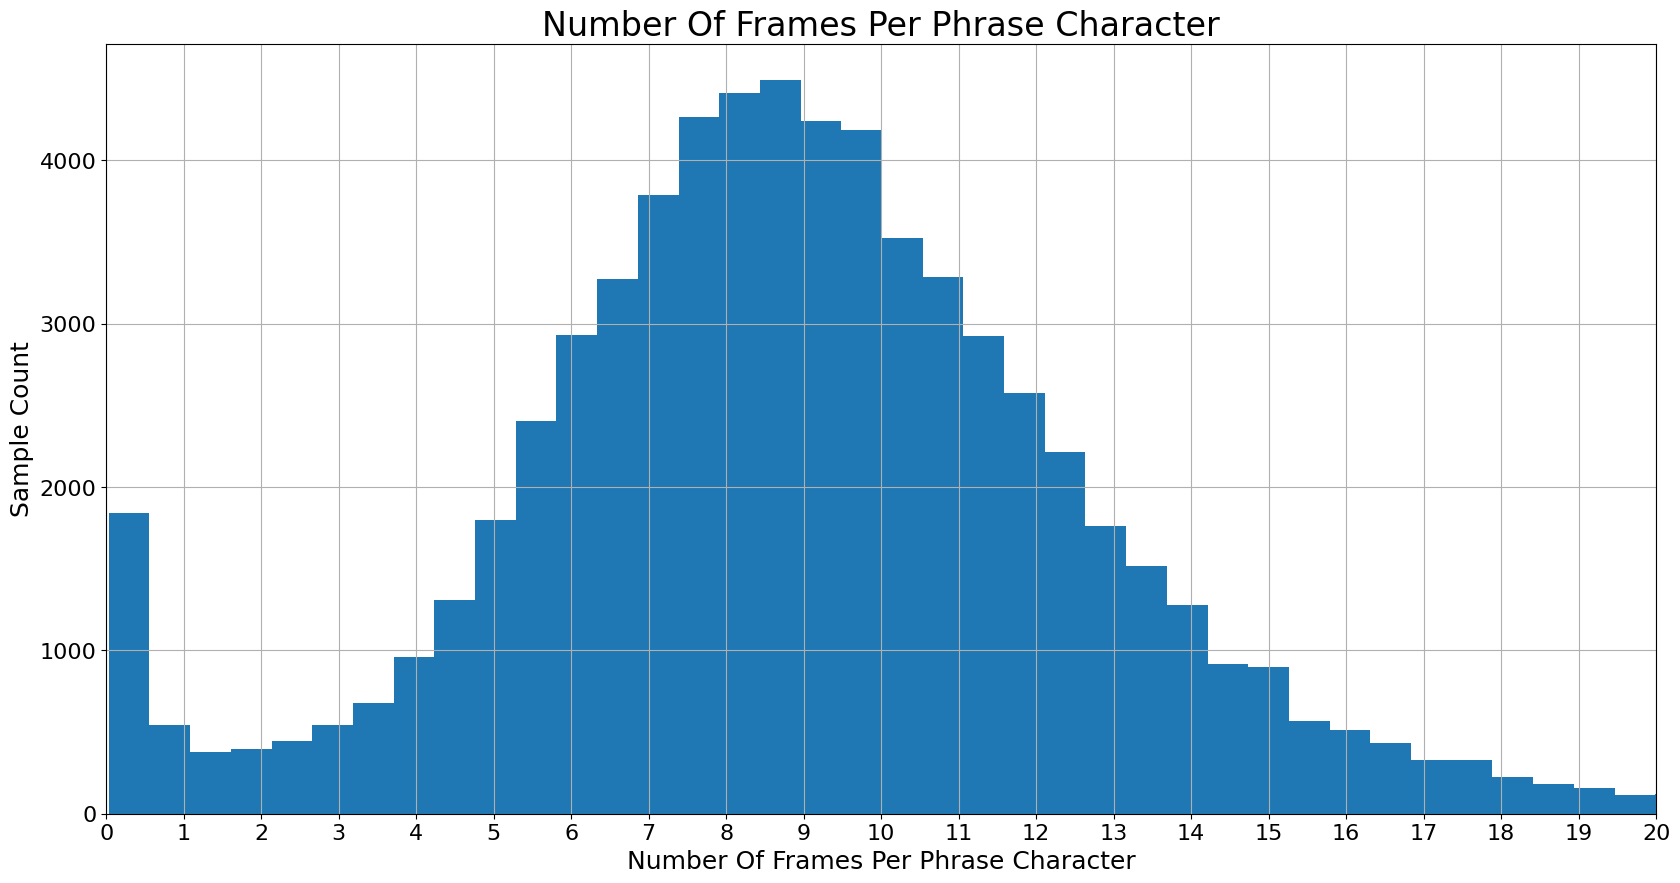

In [33]:
N_FRAMES_PER_CHARACTER_S = pd.Series(N_FRAMES_PER_CHARACTER)

display(N_FRAMES_PER_CHARACTER_S.describe(percentiles=PERCENTILES).to_frame('Value').round(2))

plt.figure(figsize=(20,10))
plt.title('Number Of Frames Per Phrase Character')
N_FRAMES_PER_CHARACTER_S.plot(kind='hist', bins=128)
# Plot till 99th percentile
p99 = math.ceil(np.percentile(N_FRAMES_PER_CHARACTER_S, 99))
plt.xticks(np.arange(0, p99+1, 1))
plt.xlim(0, p99)
plt.xlabel('Number Of Frames Per Phrase Character')
plt.ylabel('Sample Count')
plt.grid()
plt.show()

# Coordinate Statistics

  0%|          | 0/164 [00:00<?, ?it/s]

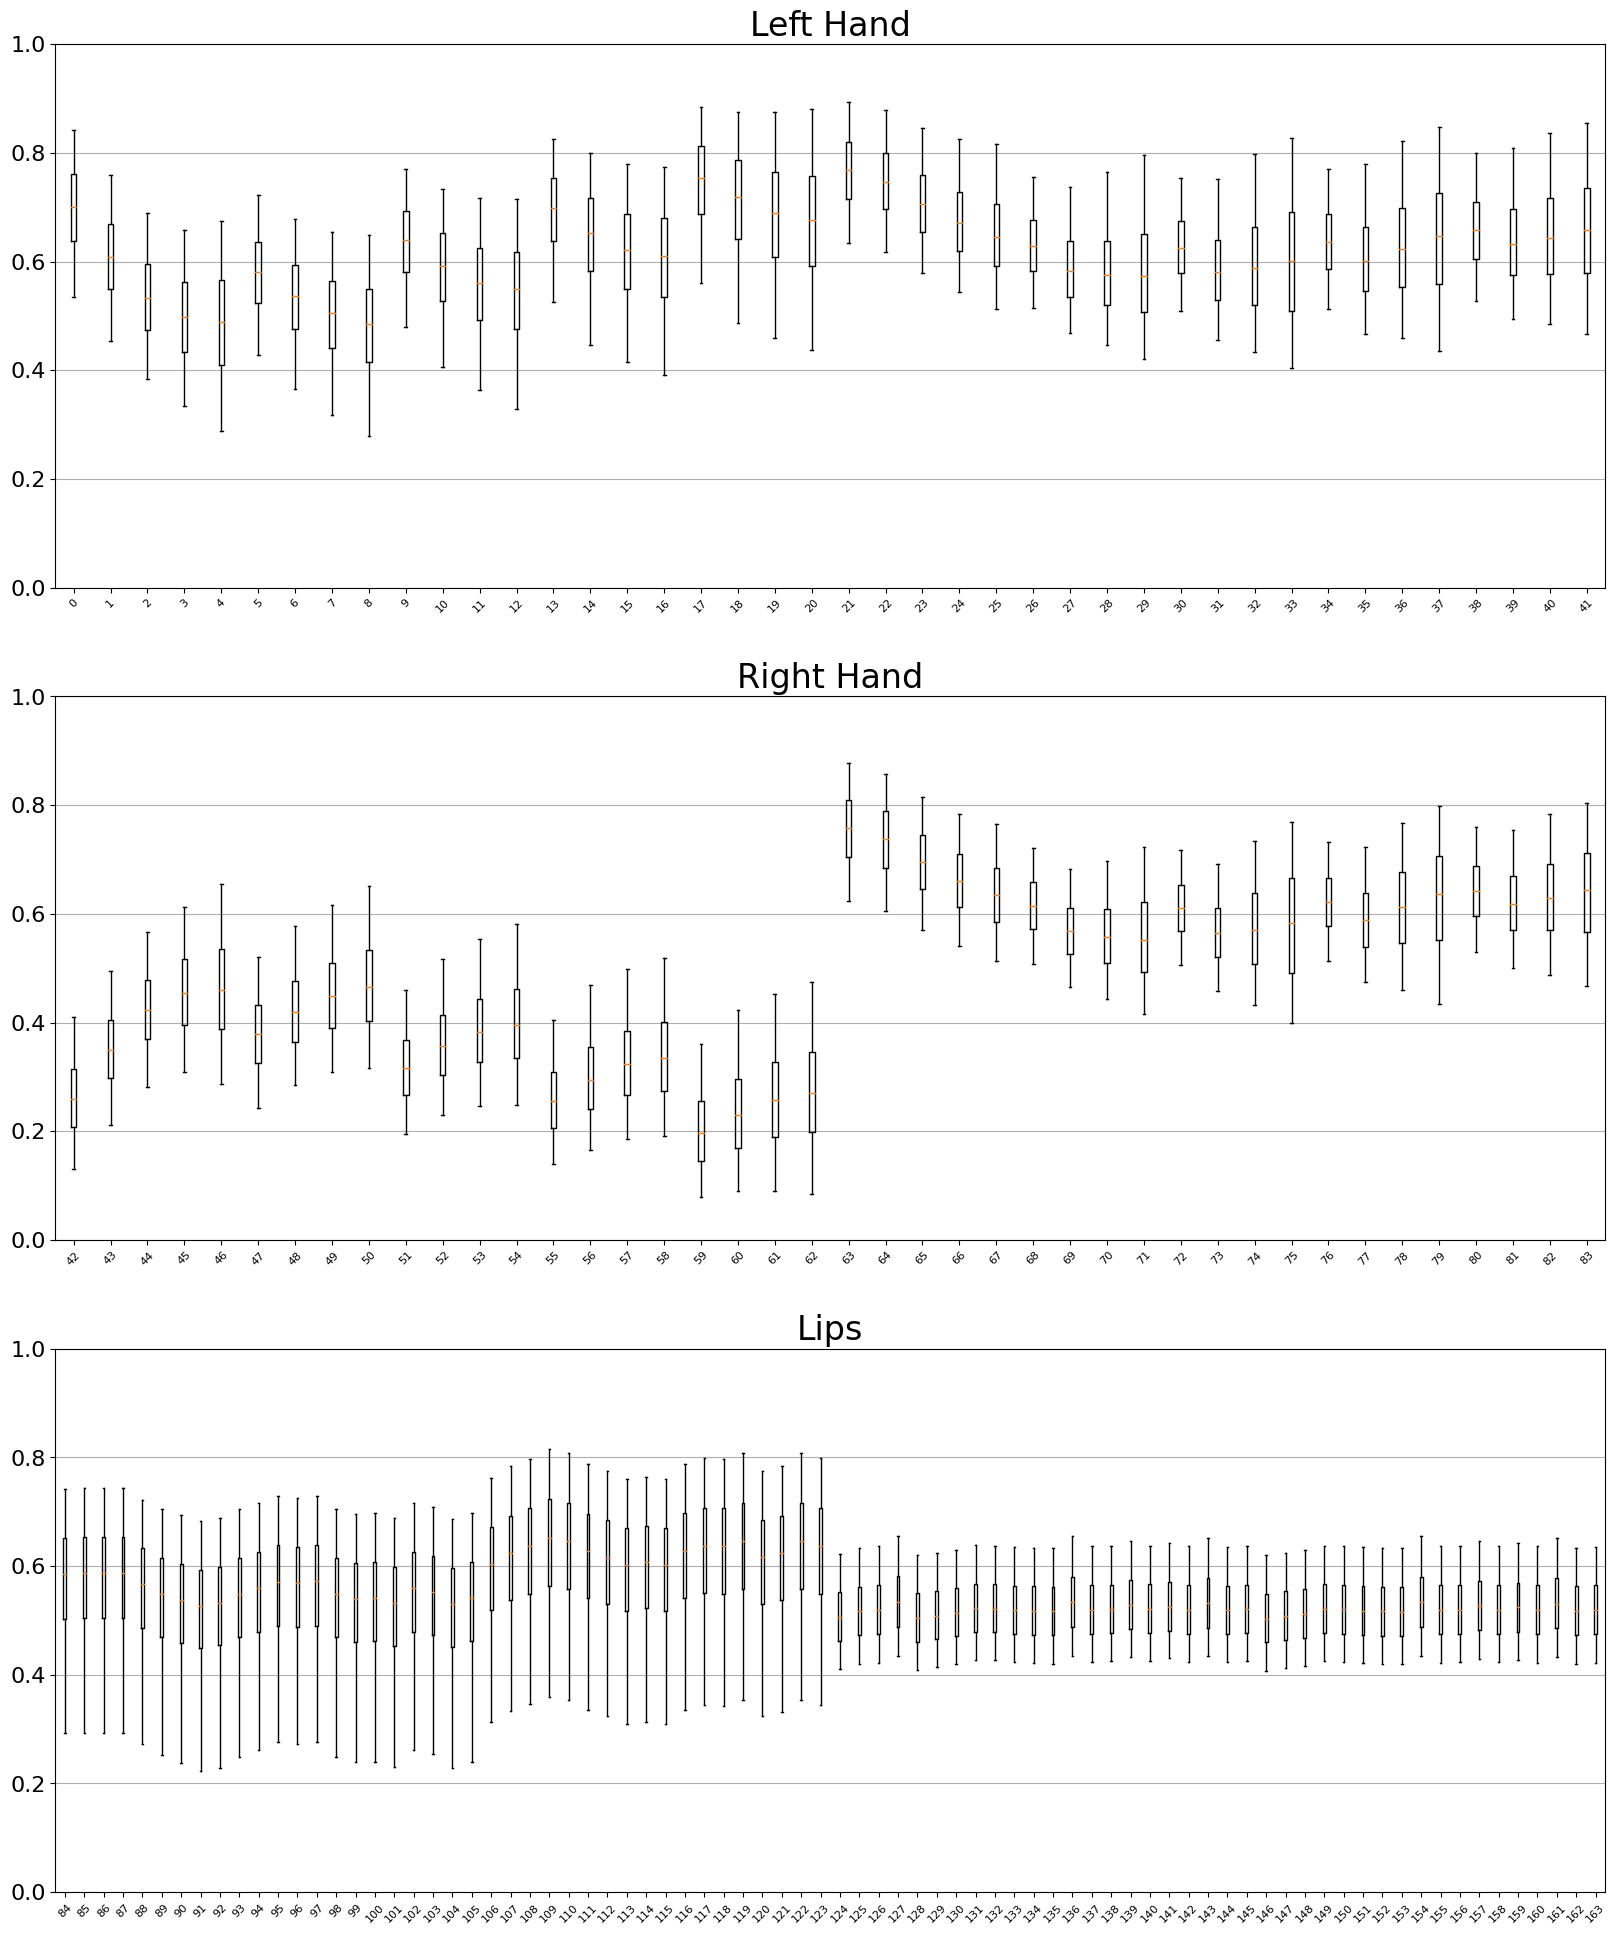

In [34]:
def get_left_right_hand_mean_std():
    # Dominant Hand Statistics
    MEANS = np.zeros([N_COLS], dtype=np.float32)
    STDS = np.zeros([N_COLS], dtype=np.float32)
    
    # Plot
    fig, axes = plt.subplots(3, figsize=(20, 3*8))
    
    # Iterate over all landmarks
    for col, v in enumerate(tqdm(X.reshape([-1, N_COLS]).T)):
        v = v[np.nonzero(v)]
        # Remove zero values as they are NaN values
        MEANS[col] = v.astype(np.float32).mean()
        STDS[col] = v.astype(np.float32).std()
        if col in LEFT_HAND_IDXS:
            axes[0].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])
        elif col in RIGHT_HAND_IDXS:
            axes[1].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])
        else:
            axes[2].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])
        
    for ax, name in zip(axes, ['Left Hand', 'Right Hand', 'Lips']):
        ax.set_title(f'{name}', size=24)
        ax.tick_params(axis='x', labelsize=8, rotation=45)
        ax.set_ylim(0.0, 1.0)
        ax.grid(axis='y')

    plt.show()
    
    return MEANS, STDS

# Get Dominant Hand Mean/Standard Deviation
MEANS, STDS = get_left_right_hand_mean_std()
# Save Mean/STD to normalize input in neural network model
np.save('MEANS.npy', MEANS)
np.save('STDS.npy', STDS)